# FootPrintNet: Una Red Neuronal Convolucional para la Clasificación Precisa de Inclinación de Huellas Podales

## Introducción al problema

El **análisis de la huella podal** mediante podograma o impresión gráfica de la planta, es una herramienta muy útil para caracterizar el apoyo de cada pie en contacto con la superficie, además, es procedimentalmente sencilla y provista de validez. Esta es utilizada principalmente en asignaturas del área biomédica tales como Kinesiología y Biomecánica, requiere de unos conocimientos previos de las asignaturas de Matemática y Biofísica. Los conceptos de línea recta, paralelismo, perpendicularidad, ángulo, longitud, área, razón, proporción, intervalo, porcentaje, los conceptos físicos de fuerza y presión, así como las leyes de Newton implicadas en la transmisión de cargas, fuerzas externas e internas, acciones y reacciones, son fundamentales para que el estudiante comprenda esta importante aplicación que permite estudiar las condiciones de bipedestación del cuerpo humano, e identificar situaciones patológicas que afectan la postura y que pueden intervenirse oportunamente. 

Un caminar correcto o una marcha adecuada es de suma importancia para la salud y el bienestar general de una persona. A continuación, se mencionan algunas razones por las cuales es relevante:

- *Funcionalidad física:* Una marcha adecuada permite que una persona realice sus actividades diarias con facilidad y eficiencia. Caminar correctamente garantiza una movilidad fluida, lo que facilita tareas como desplazarse, subir escaleras, levantar objetos, entre otras actividades básicas.

- *Salud musculoesquelética:* Una marcha adecuada implica un patrón de movimiento óptimo que distribuye de manera equilibrada la carga y el estrés en las diferentes estructuras musculoesqueléticas del cuerpo. Esto ayuda a mantener una alineación adecuada de las articulaciones, previene lesiones y minimiza el desgaste excesivo en ciertas áreas del cuerpo.

- *Coordinación y equilibrio:* Caminar correctamente implica una buena coordinación y equilibrio. Una marcha adecuada requiere que los músculos y los sistemas nervioso y vestibular trabajen juntos de manera coordinada para mantener la estabilidad durante el movimiento. Esto es esencial para prevenir caídas y lesiones relacionadas.

- *Salud cardiovascular:* La marcha regular y adecuada contribuye a mantener un sistema cardiovascular saludable. Caminar es una forma de ejercicio de bajo impacto que mejora la circulación sanguínea, fortalece el corazón y los vasos sanguíneos, y ayuda a controlar la presión arterial y el nivel de colesterol.

- *Bienestar mental:* El acto de caminar de forma correcta también tiene beneficios para la salud mental. Se ha demostrado que el ejercicio aeróbico, como caminar, promueve la liberación de endorfinas, hormonas que generan sensaciones de bienestar y reducen el estrés y la ansiedad. Una marcha adecuada puede ayudar a mejorar el estado de ánimo y la salud mental en general.

La identificación de inclinaciones en las huellas plantares supone una herramienta importante para la detección de *trastornos de la marcha*, éstos se refieren a condiciones anatómicas que afectan la capacidad del cuerpo para caminar correctamente, que a su vez, dichas alteraciones pueden tener orígenes diversos y pueden reflejar el estado de salud de diversos sistemas y aparatos del cuerpo humano que estarían causando dicho trastorno.

El **objetivo** de nuestro trabajo es crear una red neuronal que pueda identificar las inclinaciones en las huellas plantares, ésto con el propósito de facilitar el diagnóstico de un posible *trastorno de la marcha* utilizando una red neuronal que acepta una matriz de entrada con los datos proporcionados por imágenes en escala de grises y nos indique qué tipo de inclinación presenta la huella plantar.

## Librerías 

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from PIL import Image
from keras import backend as K
from keras.models import load_model
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import expand_dims
# from keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
# from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import os
import PIL
import cv2
#import opencv as cv2
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import model_from_json, model_from_yaml
import pickle
print(tf.__version__)

2.12.0


## Preparación de los datos 

In [2]:
with open('X_9_RGB.pickle', 'rb') as f :
    img = pickle.load(f)

with open('Y_9_RGB.pickle', 'rb') as f :
    labels = pickle.load(f)

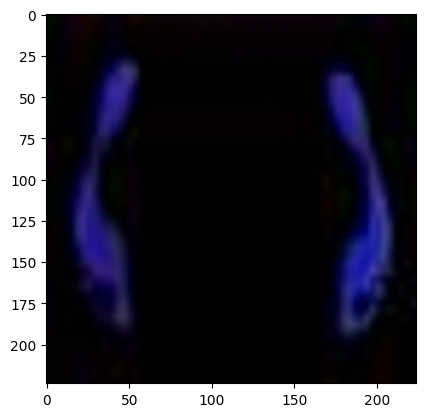

In [4]:
plt.imshow(img[4])

In [6]:
print("Dimesion de los datos totales: ", img.shape)

# Separamos los datos de entrenamiento de los de testeo
train_img, test_img, train_labels, test_labels = train_test_split(img, labels, test_size = 0.2, random_state = 14)

# Vemos la dimension de los datos
print("Dimesion de los datos de entrenamiento:", train_img.shape)
print("Etiqueta de los datos de entrenamiento:", train_labels.shape)
print("Dimesion de los datos de testeo:", test_img.shape)
print("Etiqueta de los datos de testeo:", test_labels.shape)

Dimesion de los datos totales:  (1801, 224, 224, 3)
Dimesion de los datos de entrenamiento: (1440, 224, 224, 3)
Etiqueta de los datos de entrenamiento: (1440,)
Dimesion de los datos de testeo: (361, 224, 224, 3)
Etiqueta de los datos de testeo: (361,)


## Data Augmentation

In [7]:
IMG_SHAPE  = 224
batch_size = 8

In [8]:
# Inicializamos el metodo de flujo 
image_gen_train = ImageDataGenerator(rescale = 1./255)  # Reescalamos la imagen
train_data_gen = image_gen_train.flow(
    x = train_img,
    y = train_labels,
    shuffle = True,
    batch_size = batch_size,
    seed = 14
)


image_gen_test = ImageDataGenerator(rescale = 1./255)  # Reescalamos la imagen
test_data_gen = image_gen_test.flow(
    x = test_img,
    y = test_labels,
    shuffle = False,
    batch_size = batch_size,
    seed = 14
)

## Modelo VGG16 

In [9]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(IMG_SHAPE, IMG_SHAPE, 3), include_top=False, weights="imagenet")

In [11]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(9, activation='sigmoid')(x)

In [12]:
model = tf.keras.Model(pre_trained_model.input, x)

In [13]:
model.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Entrenamiento

In [16]:
# Los valores reales que se uaron fueron steps_per_epoch = 50 y epochs = 10
vgg_classifier = model.fit(train_data_gen,
  steps_per_epoch=(train_img.shape[0]//batch_size), 
  epochs = 20, 
  batch_size = batch_size,
  verbose = 1)

Epoch 1/10
50/50 [==============================] - 97s 2s/step - loss: 1.4887 - acc: 0.4725
Epoch 2/10
50/50 [==============================] - 95s 2s/step - loss: 1.3414 - acc: 0.5325
Epoch 3/10
50/50 [==============================] - 94s 2s/step - loss: 1.2458 - acc: 0.5900
Epoch 4/10
50/50 [==============================] - 101s 2s/step - loss: 1.1116 - acc: 0.6450
Epoch 5/10
50/50 [==============================] - 104s 2s/step - loss: 1.0153 - acc: 0.6825
Epoch 6/10
50/50 [==============================] - 101s 2s/step - loss: 1.0195 - acc: 0.6875
Epoch 7/10
50/50 [==============================] - 134s 3s/step - loss: 0.8876 - acc: 0.7100
Epoch 8/10
50/50 [==============================] - 140s 3s/step - loss: 0.8326 - acc: 0.7450
Epoch 9/10
50/50 [==============================] - 140s 3s/step - loss: 0.8077 - acc: 0.7450
Epoch 10/10
50/50 [==============================] - 110s 2s/step - loss: 0.7343 - acc: 0.7625


## Testeo

In [17]:
result = model.evaluate(test_data_gen,batch_size=batch_size)
print("test_loss, test accuracy",result)

46/46 [==============================] - 121s 3s/step - loss: 0.6715 - acc: 0.8089
test_loss, test accuracy [0.6715244054794312, 0.8088642954826355]


Basado en los resultados del testeo de nuestro modelo neuronal, se puede concluir que la pérdida promedio obtenida es de 0.6715. Este valor indica el error promedio durante la etapa de prueba. Es importante destacar que un valor más bajo de pérdida es deseable, ya que indica que el modelo está realizando predicciones más precisas. En este caso, el valor de pérdida obtenido es relativamente alto, lo que sugiere que nuestras predicciones pueden tener cierto grado de imprecisión.

Por otro lado, la precisión obtenida en el testeo es del 80.89%. Esto significa que el modelo ha clasificado correctamente el tipo de inclinación de las huellas de pies en aproximadamente el 80.89% de los casos. Esta precisión es considerada decente, ya que indica que el modelo está aprendiendo y haciendo predicciones razonablemente buenas en la tarea de clasificación.

## Resultados

In [33]:
Y_pred = model.predict(test_data_gen, 50) # aqui volvi a usar test_img.shape[0]//batch_size
y_pred = np.argmax(Y_pred, axis=1)
print('Matriz de confusión ')
print(confusion_matrix(test_data_gen.y, y_pred))
print('')
print('Reporte de clasificación ')
target_names = [
    "Pie normal", 
    "Pie izquierdo inclinado hacia adelante", 
    "Pie derecho inclinado hacia adelante",
    "Pie izquierdo inclinado hacia atrás",
    "Pie derecho inclinado hacia atrás",
    "Inclinación del lado izquierdo",
    "Inclinación hacia la derecha",
    "Pie izquierdo torcido",
    "Pie derecho torcido",
]
print(classification_report(test_data_gen.y, y_pred, target_names=target_names))

46/46 [==============================] - 82s 2s/step
Matriz de confusión 
[[25  0  1  0  0  0  0  2  0]
 [ 3 21  1  0  0  0  7 13  0]
 [ 1  1 31  0  0  0  0  7  2]
 [ 0  0  0 28  1  0  9  0  0]
 [ 0  0  0  2 28  1  2  1  0]
 [ 1  0  0  0  0 29  1  0  4]
 [ 0  0  0  0  0  0 41  0  0]
 [ 0  0  0  0  0  0  0 45  5]
 [ 0  0  0  0  1  0  0  3 44]]

Reporte de clasificación 
                                        precision    recall  f1-score   support

                            Pie normal       0.83      0.89      0.86        28
Pie izquierdo inclinado hacia adelante       0.95      0.47      0.63        45
  Pie derecho inclinado hacia adelante       0.94      0.74      0.83        42
   Pie izquierdo inclinado hacia atrás       0.93      0.74      0.82        38
     Pie derecho inclinado hacia atrás       0.93      0.82      0.87        34
        Inclinación del lado izquierdo       0.97      0.83      0.89        35
          Inclinación hacia la derecha       0.68      1.00      0.

La red neuronal muestra resultados prometedores en la clasificación de diferentes tipos de inclinación de huellas de pies. La mayoría de las clases tienen altos valores de precisión, recall y F1-score, lo que indica que el modelo es capaz de identificar correctamente esas clases. Por ejemplo, las clases "Pie normal", "Pie izquierdo inclinado hacia adelante" y "Pie derecho inclinado hacia adelante" tienen altos valores de precisión (83%, 95% y 94% respectivamente), lo que indica que el modelo hace predicciones precisas para estas categorías.

Sin embargo, algunas clases muestran valores más bajos en algunas métricas. Por ejemplo, la clase "Inclinación hacia la derecha" tiene una precisión del 68%, lo que indica que el modelo puede tener dificultades para identificar correctamente esta inclinación en particular.

En general, el modelo tiene un accuracy (precisión global) del 81%, lo que significa que acierta en aproximadamente el 81% de las predicciones en el conjunto de datos de prueba. Aunque esta cifra es aceptable, se debe tener en cuenta que existen oportunidades para mejorar el rendimiento, especialmente en las clases con valores más bajos en algunas métricas.

## Gráfica de pérdidas y de precisión 

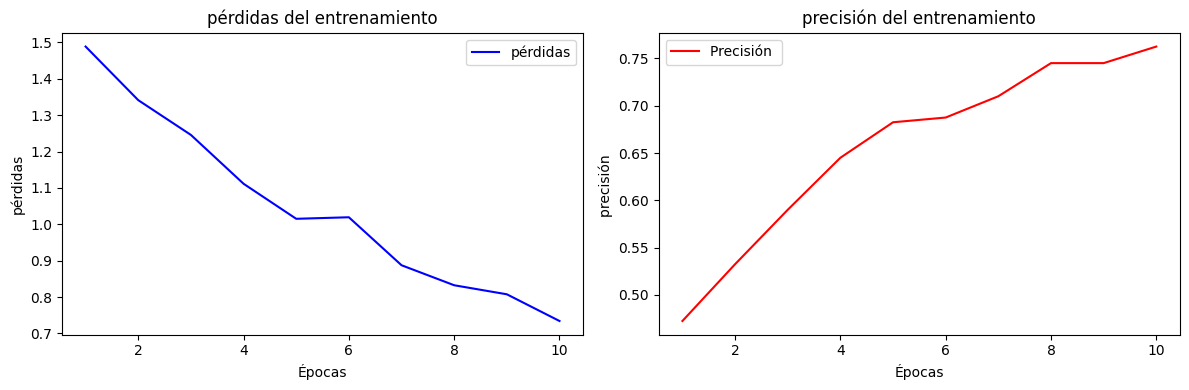

In [34]:
# Obtenemos el historial de entrenamiento
train_loss = vgg_classifier.history['loss']
train_accuracy = vgg_classifier.history['acc']

# Creamos el gráfico
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# gráfica de pérdidas 
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='pérdidas')
plt.title('pérdidas del entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('pérdidas')
plt.legend()

# gráfica de precisión 
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Precisión ')
plt.title('precisión del entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('precisión ')
plt.legend()

plt.tight_layout()
plt.show()

## Guardar modelo

In [35]:
model.save('modeloVGG16pies', overwrite=True)
tf.keras.models.save_model(model,"modeloVGG16pies.h5") # as .h5

INFO:tensorflow:Assets written to: modeloVGG16pies\assets


INFO:tensorflow:Assets written to: modeloVGG16pies\assets


---------------------

> Referencias:
- https://www.kaggle.com/datasets/mahdiislam/pressure-sensor-heatmaprgb
- Shiang, T. Y., Lee, S. H., Lee, S. J. y Chu, W. C. (1998). Evaluating different footprint parameters as a predictor of arch height. IEEE Engineering in Medicine and Biology Magazine, 17 (6), 62-66.
